# (PyTorch) Cornell Movie Review Dataset

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

from yaringal_dataset import loader
from weight_drop import WeightDrop
from embed_regularize import embedded_dropout
from locked_dropout import LockedDropout

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (8, 5)

# Global params:
NB_WORDS = 20000
SKIP_TOP = 0
TEST_SPLIT = 0.2
INIT_SEED = 2017
GLOBAL_SEED = 2018
MAXLEN = 200
BATCH_SIZE = 128
TEST_BATCH_SIZE = 512

In [2]:
dataset = loader(INIT_SEED, MAXLEN, NB_WORDS, SKIP_TOP, TEST_SPLIT)

X_train, X_test, Y_train, Y_test = dataset.X_train, dataset.X_test, dataset.Y_train, dataset.Y_test
mean_y_train, std_y_train = dataset.mean_y_train, dataset.std_y_train

10620 train sequences
2655 test sequences
Pad sequences (samples x time)
X_train shape: (10620, 200)
X_test shape: (2655, 200)


In [3]:
def inverse_transform(v):
    return v * std_y_train + mean_y_train 

In [4]:
class Model(nn.Module):
    def __init__(self, nb_words, hidden_size=128, embedding_size=128, n_layers=1,
                 wdrop=0.25, odrop=0.25, edrop=0.1, idrop=0.25, variational=False,
                 standard_dropout=False, batch_first=True):
        super(Model, self).__init__()
        self.standard_dropout = standard_dropout
        self.lockdrop = LockedDropout(batch_first=batch_first)
        self.odrop = odrop
        self.idrop = idrop
        self.edrop = edrop
        self.n_layers = n_layers
        self.embedding = nn.Embedding(nb_words, embedding_size)
        self.rnns = [
            nn.LSTM(embedding_size if l == 0 else hidden_size,
                   hidden_size, num_layers=1, batch_first=batch_first)
            for l in range(n_layers)
        ]
        if wdrop:
            self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop, variational=variational)
                         for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.fill_(0)
        self.output_layer.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, X):
        emb = embedded_dropout(self.embedding, X, dropout=self.edrop if self.training else 0)
        if self.standard_dropout:
            raw_output = F.dropout(emb, p=self.idrop, training=self.training)
        else:
            raw_output = self.lockdrop(emb, self.idrop)
        new_hidden, new_cell_state = [], []
        for l, rnn in enumerate(self.rnns):
            raw_output, (new_h, new_c) = rnn(raw_output)
            if self.standard_dropout:
                raw_output = F.dropout(raw_output, p=self.odrop, training=self.training)
            else:
                raw_output = self.lockdrop(raw_output, self.odrop)         
            new_hidden.append(new_h)
            new_cell_state.append(new_c)
        hidden = torch.cat(new_hidden, 0)
        cell_state = torch.cat(new_cell_state, 0)
        final_output = self.output_layer(raw_output)
        return final_output[:, -1, 0], hidden, cell_state

In [5]:
MC_ROUNDS = 10
def fit(model, optimizer, X_train_tensor, Y_train_tensor, 
        X_test_tensor, Y_test_tensor, n_epochs=30, mc_dropout=True):
    epoch_losses = []
    criterion = torch.nn.MSELoss()
    for epoch in range(n_epochs):
        indices = torch.randperm(len(X_train)).cuda()
        losses, losses_raw = [], []
        model.train()
        for i in range(0, len(X_train), BATCH_SIZE): #tqdm_notebook(range(0, len(X_train), BATCH_SIZE)):
            optimizer.zero_grad()
            pred, _, _ = model(Variable(X_train_tensor[indices[i:(i+BATCH_SIZE)]]))
            loss_raw = criterion(
                pred,
                Variable(Y_train_tensor[indices[i:(i+BATCH_SIZE)]], requires_grad=False)
            )
            loss = F.mse_loss(inverse_transform(pred),
                              inverse_transform(
                                  Variable(Y_train_tensor[indices[i:(i+BATCH_SIZE)]], requires_grad=False)))
            losses_raw.append(loss_raw.data.cpu()[0])
            losses.append(loss.data.cpu()[0])
            loss_raw.backward()
            optimizer.step()
        train_loss = np.mean(losses)** 0.5
        train_loss_raw = np.mean(losses_raw)
        # Standard dropout approximation
        losses, losses_raw = [], []
        model.eval()    
        for i in range(0, len(X_test), TEST_BATCH_SIZE):
            pred_test, _, _ = model(Variable(X_test_tensor[i:(i+TEST_BATCH_SIZE)], volatile=True))
            loss_raw = F.mse_loss(pred_test, Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)]))
            loss = F.mse_loss(inverse_transform(pred_test),
                              inverse_transform(Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)])))
            losses_raw.append(loss_raw.data.cpu()[0])
            losses.append(loss.data.cpu()[0])
        std_test_loss = np.mean(losses) ** 0.5
        std_test_loss_raw = np.mean(losses_raw)
        if mc_dropout:
            # MC dropout
            losses, losses_raw = [], []
            model.train()
            for i in range(0, len(X_test), TEST_BATCH_SIZE):
                pred_list = []
                for j in range(MC_ROUNDS):
                    pred_test, _, _ = model(Variable(X_test_tensor[i:(i+TEST_BATCH_SIZE)], volatile=True))
                    pred_list.append(pred_test.unsqueeze(0))
                pred_all = torch.mean(torch.cat(pred_list, 0), 0)
                loss_raw = F.mse_loss(pred_all, Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)]))
                loss = F.mse_loss(inverse_transform(pred_all),
                                  inverse_transform(Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)])))        
                losses_raw.append(loss_raw.data.cpu()[0])
                losses.append(loss.data.cpu()[0])    
            mc_test_loss = np.mean(losses) ** 0.5
            mc_test_loss_raw = np.mean(losses_raw)
            epoch_losses.append([
                train_loss, std_test_loss, mc_test_loss,
                train_loss_raw, std_test_loss_raw, mc_test_loss_raw
            ])
            print("Epoch: {} Train: {:.4f}/{:.4f}, Val Std: {:.4f}/{:.4f}, Val MC: {:.4f}/{:.4f}".format(
                epoch, train_loss, std_test_loss_raw, std_test_loss, std_test_loss_raw, mc_test_loss, mc_test_loss_raw))
        else:
            epoch_losses.append([train_loss, std_test_loss, mc_test_loss])
            print("Epoch: {} Train: {:.4f}/{:.4f}, Val Std: {:.4f}/{:.4f}".format(
                epoch, train_loss, std_test_loss_raw, std_test_loss, std_test_loss_raw))
    return epoch_losses

In [6]:
Y_train_tensor =  torch.from_numpy(Y_train).float().cuda()
Y_test_tensor =  torch.from_numpy(Y_test).float().cuda()
X_train_tensor =  torch.from_numpy(X_train).long().cuda()
X_test_tensor =  torch.from_numpy(X_test).long().cuda()

## Weight Dropped LSTM (w Embedding Dropout)

In [7]:
model_1 = Model(NB_WORDS + dataset.index_from, wdrop=0.02, odrop=0.1, edrop=0.2, idrop=0.1)
model_1.cuda()
optimizer = torch.optim.Adam([
            {'params': model_1.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4}
        ],)
epoch_losses_1 = fit(
    model_1, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=100)

Applying weight drop of 0.02 to weight_hh_l0


/home/ceshine/miniconda3/envs/ds36/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Epoch: 0 Train: 0.1853/0.9990, Val Std: 0.1852/0.9990, Val MC: 0.1852/0.9989
Epoch: 1 Train: 0.1852/0.9985, Val Std: 0.1851/0.9985, Val MC: 0.1852/0.9988
Epoch: 2 Train: 0.1851/0.9978, Val Std: 0.1851/0.9978, Val MC: 0.1851/0.9977
Epoch: 3 Train: 0.1849/0.9972, Val Std: 0.1850/0.9972, Val MC: 0.1850/0.9970
Epoch: 4 Train: 0.1846/0.9954, Val Std: 0.1849/0.9954, Val MC: 0.1849/0.9954
Epoch: 5 Train: 0.1840/0.9876, Val Std: 0.1841/0.9876, Val MC: 0.1842/0.9882
Epoch: 6 Train: 0.1802/0.9327, Val Std: 0.1789/0.9327, Val MC: 0.1792/0.9350
Epoch: 7 Train: 0.1677/0.7143, Val Std: 0.1566/0.7143, Val MC: 0.1577/0.7248
Epoch: 8 Train: 0.1528/0.6970, Val Std: 0.1547/0.6970, Val MC: 0.1568/0.7159
Epoch: 9 Train: 0.1414/0.6275, Val Std: 0.1468/0.6275, Val MC: 0.1480/0.6384
Epoch: 10 Train: 0.1346/0.6027, Val Std: 0.1438/0.6027, Val MC: 0.1455/0.6164
Epoch: 11 Train: 0.1266/0.5992, Val Std: 0.1434/0.5992, Val MC: 0.1436/0.6008
Epoch: 12 Train: 0.1246/0.6387, Val Std: 0.1481/0.6387, Val MC: 0.1498/0.6

In [11]:
print("Best RMSE: {:.4f} Best Epoch: {}".format(
    np.min([x[2] for x in epoch_losses_1]), 
    np.argmin([x[2] for x in epoch_losses_1]) + 1
))


Best RMSE: 0.1391 Best Epoch: 18


## No Dropout

In [12]:
model_2 = Model(NB_WORDS + dataset.index_from, wdrop=0, odrop=0, edrop=0, idrop=0)
model_2.cuda()
optimizer = torch.optim.Adam([
            {'params': model_2.parameters(), 'lr': 1e-4}
        ],)
epoch_losses_2 = fit(
    model_2, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=100)

Epoch: 0 Train: 0.1853/0.9989, Val Std: 0.1852/0.9989, Val MC: 0.1852/0.9989
Epoch: 1 Train: 0.1851/0.9981, Val Std: 0.1851/0.9981, Val MC: 0.1851/0.9981
Epoch: 2 Train: 0.1850/0.9970, Val Std: 0.1850/0.9970, Val MC: 0.1850/0.9970
Epoch: 3 Train: 0.1846/0.9949, Val Std: 0.1848/0.9949, Val MC: 0.1848/0.9949
Epoch: 4 Train: 0.1835/0.9790, Val Std: 0.1833/0.9790, Val MC: 0.1833/0.9790
Epoch: 5 Train: 0.1706/0.7772, Val Std: 0.1633/0.7772, Val MC: 0.1633/0.7772
Epoch: 6 Train: 0.1442/0.6491, Val Std: 0.1493/0.6491, Val MC: 0.1493/0.6491
Epoch: 7 Train: 0.1280/0.6170, Val Std: 0.1455/0.6170, Val MC: 0.1455/0.6170
Epoch: 8 Train: 0.1151/0.5919, Val Std: 0.1425/0.5919, Val MC: 0.1425/0.5919
Epoch: 9 Train: 0.1065/0.5908, Val Std: 0.1424/0.5908, Val MC: 0.1424/0.5908
Epoch: 10 Train: 0.1004/0.5949, Val Std: 0.1429/0.5949, Val MC: 0.1429/0.5949
Epoch: 11 Train: 0.0945/0.5888, Val Std: 0.1422/0.5888, Val MC: 0.1422/0.5888
Epoch: 12 Train: 0.0892/0.6097, Val Std: 0.1447/0.6097, Val MC: 0.1447/0.6

In [13]:
print("Best RMSE: {:.4f} Best Epoch: {}".format(
    np.min([x[2] for x in epoch_losses_2]), 
    np.argmin([x[2] for x in epoch_losses_2]) + 1
))


Best RMSE: 0.1422 Best Epoch: 12


## Naive Dropout (w/o Embedding Dropout)

In [14]:
model_3 = Model(NB_WORDS + dataset.index_from, 
                wdrop=0, odrop=0.2, edrop=0, idrop=0.2, standard_dropout=True)
model_3.cuda()
optimizer = torch.optim.Adam([
            {'params': model_3.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4}
        ],)
epoch_losses_3 = fit(
    model_3, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=100)

Epoch: 0 Train: 0.1853/0.9995, Val Std: 0.1852/0.9995, Val MC: 0.1852/0.9995
Epoch: 1 Train: 0.1852/0.9988, Val Std: 0.1852/0.9988, Val MC: 0.1852/0.9987
Epoch: 2 Train: 0.1851/0.9981, Val Std: 0.1851/0.9981, Val MC: 0.1851/0.9984
Epoch: 3 Train: 0.1849/0.9973, Val Std: 0.1850/0.9973, Val MC: 0.1851/0.9975
Epoch: 4 Train: 0.1848/0.9960, Val Std: 0.1849/0.9960, Val MC: 0.1849/0.9959
Epoch: 5 Train: 0.1844/0.9928, Val Std: 0.1846/0.9928, Val MC: 0.1846/0.9927
Epoch: 6 Train: 0.1824/0.9544, Val Std: 0.1810/0.9544, Val MC: 0.1810/0.9545
Epoch: 7 Train: 0.1666/0.7308, Val Std: 0.1584/0.7308, Val MC: 0.1587/0.7332
Epoch: 8 Train: 0.1437/0.6152, Val Std: 0.1453/0.6152, Val MC: 0.1456/0.6172
Epoch: 9 Train: 0.1266/0.5882, Val Std: 0.1421/0.5882, Val MC: 0.1422/0.5892
Epoch: 10 Train: 0.1162/0.5849, Val Std: 0.1417/0.5849, Val MC: 0.1416/0.5844
Epoch: 11 Train: 0.1093/0.5688, Val Std: 0.1397/0.5688, Val MC: 0.1402/0.5727
Epoch: 12 Train: 0.1040/0.5939, Val Std: 0.1428/0.5939, Val MC: 0.1432/0.5

In [16]:
print("Best RMSE: {:.4f} Best Epoch: {}".format(
    np.min([x[2] for x in epoch_losses_3]), 
    np.argmin([x[2] for x in epoch_losses_3]) + 1
))


Best RMSE: 0.1402 Best Epoch: 12


## Variational LSTM

In [17]:
model_4 = Model(NB_WORDS + dataset.index_from, wdrop=0.02, odrop=0.1, edrop=0.2, idrop=0.1, variational=True)
model_4.cuda()
optimizer = torch.optim.Adam([
            {'params': model_4.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4}
        ],)
epoch_losses_4 = fit(
    model_4, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=100)

Applying weight drop of 0.02 to weight_hh_l0


/home/ceshine/miniconda3/envs/ds36/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Epoch: 0 Train: 0.1853/0.9991, Val Std: 0.1852/0.9991, Val MC: 0.1852/0.9991
Epoch: 1 Train: 0.1852/0.9983, Val Std: 0.1851/0.9983, Val MC: 0.1851/0.9984
Epoch: 2 Train: 0.1851/0.9976, Val Std: 0.1851/0.9976, Val MC: 0.1851/0.9978
Epoch: 3 Train: 0.1849/0.9965, Val Std: 0.1850/0.9965, Val MC: 0.1850/0.9968
Epoch: 4 Train: 0.1847/0.9947, Val Std: 0.1848/0.9947, Val MC: 0.1848/0.9949
Epoch: 5 Train: 0.1841/0.9884, Val Std: 0.1842/0.9884, Val MC: 0.1842/0.9880
Epoch: 6 Train: 0.1812/0.9358, Val Std: 0.1792/0.9358, Val MC: 0.1787/0.9301
Epoch: 7 Train: 0.1752/0.9160, Val Std: 0.1773/0.9160, Val MC: 0.1779/0.9218
Epoch: 8 Train: 0.1673/0.7405, Val Std: 0.1594/0.7405, Val MC: 0.1621/0.7650
Epoch: 9 Train: 0.1536/0.6974, Val Std: 0.1547/0.6974, Val MC: 0.1549/0.6989
Epoch: 10 Train: 0.1472/0.6881, Val Std: 0.1537/0.6881, Val MC: 0.1542/0.6924
Epoch: 11 Train: 0.1420/0.6593, Val Std: 0.1504/0.6593, Val MC: 0.1495/0.6510
Epoch: 12 Train: 0.1345/0.6698, Val Std: 0.1516/0.6698, Val MC: 0.1466/0.6

In [19]:
print("Best RMSE: {:.4f} Best Epoch: {}".format(
    np.min([x[2] for x in epoch_losses_4]), 
    np.argmin([x[2] for x in epoch_losses_4]) + 1
))


Best RMSE: 0.1454 Best Epoch: 27


## Variational LSTM w/o Recurrent Dropout

In [20]:
model_5 = Model(NB_WORDS + dataset.index_from, wdrop=0, odrop=0.1, edrop=0.2, idrop=0.1)
model_5.cuda()
optimizer = torch.optim.Adam([
            {'params': model_5.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4}
        ],)
epoch_losses_5 = fit(
    model_5, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=100)

Epoch: 0 Train: 0.1853/0.9991, Val Std: 0.1852/0.9991, Val MC: 0.1852/0.9992
Epoch: 1 Train: 0.1852/0.9985, Val Std: 0.1851/0.9985, Val MC: 0.1852/0.9987
Epoch: 2 Train: 0.1851/0.9979, Val Std: 0.1851/0.9979, Val MC: 0.1851/0.9978
Epoch: 3 Train: 0.1849/0.9970, Val Std: 0.1850/0.9970, Val MC: 0.1850/0.9971
Epoch: 4 Train: 0.1847/0.9955, Val Std: 0.1849/0.9955, Val MC: 0.1849/0.9956
Epoch: 5 Train: 0.1842/0.9914, Val Std: 0.1845/0.9914, Val MC: 0.1845/0.9916
Epoch: 6 Train: 0.1822/0.9645, Val Std: 0.1820/0.9645, Val MC: 0.1822/0.9668
Epoch: 7 Train: 0.1761/0.8923, Val Std: 0.1750/0.8923, Val MC: 0.1758/0.8998
Epoch: 8 Train: 0.1649/0.7838, Val Std: 0.1640/0.7838, Val MC: 0.1643/0.7860
Epoch: 9 Train: 0.1483/0.6490, Val Std: 0.1493/0.6490, Val MC: 0.1508/0.6624
Epoch: 10 Train: 0.1371/0.6333, Val Std: 0.1474/0.6333, Val MC: 0.1496/0.6519
Epoch: 11 Train: 0.1288/0.6145, Val Std: 0.1452/0.6145, Val MC: 0.1463/0.6234
Epoch: 12 Train: 0.1243/0.5999, Val Std: 0.1435/0.5999, Val MC: 0.1442/0.6

In [21]:
print("Best RMSE: {:.4f} Best Epoch: {}".format(
    np.min([x[2] for x in epoch_losses_5]), 
    np.argmin([x[2] for x in epoch_losses_5]) + 1
))

Best RMSE: 0.1404 Best Epoch: 22


## Visualizations

In [52]:
bins = np.arange(-0.012, 0.005, 0.001)

(array([-0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005]),
 <a list of 6 Text xticklabel objects>)

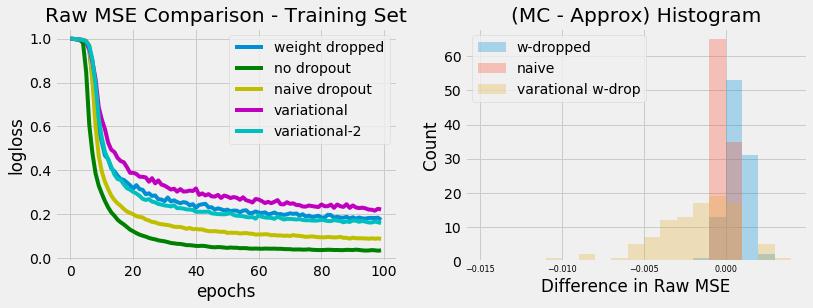

In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Raw MSE Comparison - Training Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[3] for x in epoch_losses_1], label="weight dropped")
plt.plot(np.arange(len(epoch_losses_2)), [x[3] for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[3] for x in epoch_losses_3], "y-", label="naive dropout")
plt.plot(np.arange(len(epoch_losses_4)), [x[3] for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_5)), [x[3] for x in epoch_losses_5], "c-", label="variational-2")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.subplot(1, 2, 2)
plt.title("(MC - Approx) Histogram")
plt.hist([x[2] - x[1] for x in epoch_losses_1], bins=bins, alpha=0.3, label="w-dropped")
plt.hist([x[2] - x[1] for x in epoch_losses_3], bins=bins, alpha=0.3, label="naive")
plt.hist([x[2] - x[1] for x in epoch_losses_4], bins=bins, alpha=0.3, label="varational w-drop")
plt.legend(loc='best')
plt.xlabel("Difference in Raw MSE")
plt.ylabel("Count")
plt.xticks(fontsize=8, rotation=0)

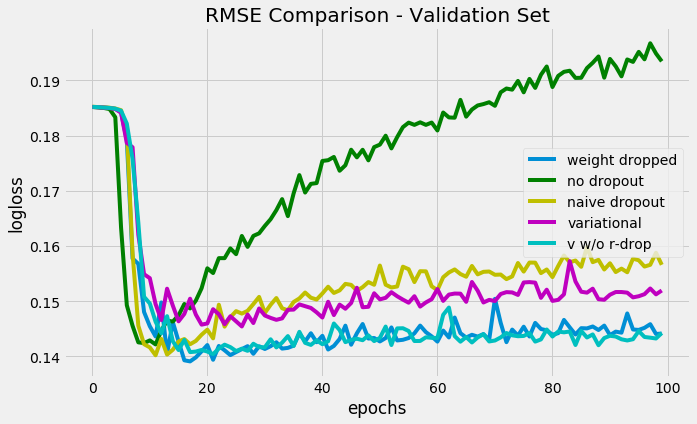

In [60]:
plt.figure(figsize=(10, 6))
plt.title("RMSE Comparison - Validation Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[2] for x in epoch_losses_1], label="weight dropped")
plt.plot(np.arange(len(epoch_losses_2)), [x[2] for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[2] for x in epoch_losses_3], "y-", label="naive dropout")
plt.plot(np.arange(len(epoch_losses_4)), [x[2] for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_5)), [x[2] for x in epoch_losses_5], "c-", label="v w/o r-drop")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("logloss")